<h1><center>DSA 4212: Year 2019-2020</center></h1>
<h3><center> Assignment 1 (Deadline: 27 March 2020 at 23:59) </center></h3>
<h2><center> Group Number: ???? </center></h2>
<h2><center> Group Member 1: Joyce Lim Li Jie, Student ID </center></h2>
<h2><center> Group Member 2: Ryan Teo Jin Chuan, A0164337A </center></h2>
<h2><center> Group Member 3: Wong Jia Hwee, Student ID </center></h2>

In [1]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) 

import jax; import jax.numpy as np

import pylab as plt
import imageio; import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn import metrics
import pandas as pd; import time; import scipy

# 1. Data Pre-Processing

In [2]:
#load attributes csv file
attribute = pd.read_csv("celeba.csv")

#"attribute" is a dictionary containing several attributes for each image
#attribute.keys()

In [3]:
#let us list all the files in the image directory
path = "img_celeba_small"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]
nb_img = len(all_img)

#let us keep only the relevant rows in attributes
attribute = attribute[:20000]

## 1.1 Creating training and validation datasets

We take the 15,000 training dataset and split it into a smaller training and validation dataset to improve the training outcome.

In [4]:
# select first 15000 rows for training dataset
train = attribute[:15000]
train = train['Young']

# select last 5000 rows for test dataset
test = attribute[15000:20000]
test = test['Young']

In [11]:
is_Young = train==1
is_Old = train==-1

# subset training set by young/old
train_y = train[is_Young] 
train_o = train[is_Old]

# number of old people in training data
n_old = len(train_o)

# proportion of old people in whole dataset
len(train_o)/len(train_y)

0.28545719427543065

Of the 15,000 images in the training data, 3331 (28.5%) are old. We create: 
1. a training set (50% old & 50% young) that is balanced containing 80% of all old data
2. a validation set (28.5% old & 71.5% young) containing 20% of all old data

Our training set should be balanced so that our classifier has sufficient data on young and old faces, while our validation set should imitate the age proportion in reality.

In [18]:
# sample 3331 observations from all young data in training set
onp.random.seed(0)
y_pindex = onp.random.choice(len(train_y), 5001, replace=False)
o_pindex = onp.asarray(list(range(n_old)))

In [19]:
train_n = 2665 # 80% of number of old samples

# select prelim training & validation data
ptrain_y = train_y.iloc[y_pindex[:train_n]]
pval_y = train_y.iloc[y_pindex[train_n:]]

ptrain_o = train_o.iloc[o_pindex[:train_n]]
pval_o = train_o.iloc[o_pindex[train_n:]]

# collate prelim training data (5330 obs, 50% each class)
ptrain = ptrain_y.append(ptrain_o)
ptrain = ptrain.sample(frac=1) # shuffle training set

# collate prelim test data (1332 obs, 50% each class)
pval = pval_y.append(pval_o)
pval = pval.sample(frac=1) # shuffle validation set

`ptrain` is a 1 x 5330 array with the indicator values $\{-1, 1\}$ for 2665 old and 2665 young. 

`pval` is a 1 x 3002 array with the indicator values $\{-1, 1\}$ for 666 old and 2336 young. 

## 1.2 Image Pre-Processing

The images were initially loaded in grayscale with their original size of 218 by 178 pixels. The pixel intensity was then rescaled to [0,1]. To remove parts of the image irrelevant to a person's age (outside of the face), the images were cropped to only include the range [50:185, 40:135]. The resulting images used for analysis are 135 by 95 pixels.

In [31]:
h = 218 # original image height
w = 178 # original image weight
h_n = 185-50 # height after cropping
w_n = 135-40 # width after cropping

In [32]:
# load the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_img = onp.zeros((ntrain_img,h_n,w_n))

for k in range(ntrain_img):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2) # grayscale
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    ptrain_img[k,:,:] = im

In [33]:
# load the images from the prelim validation set
nval_img = len(pval)
pval_ind = pval.index.values
pval_img = onp.zeros((nval_img,h_n,w_n))

for k in range(nval_img):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2) # grayscale
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    pval_img[k,:,:] = im

In [34]:
# load the images from the test set
ntest_img = 5000
ptest_img = onp.zeros((ntest_img,h_n,w_n))

for k in range(ntest_img):
    im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2) # grayscale
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    ptest_img[k,:,:] = im

In [ ]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = ptrain_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = ptrain.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

In [ ]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = pval_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = pval.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

In [ ]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = ptest_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = test.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

`ptrain` is a 1 x 5330 array with the indicator values $\{-1, 1\}$ for old and young. `ptrain_img` is a 5330 x 135 x 95 array that contains the relevant images for the preliminary training data. 

`pval` is a 1 x 2336 array with the indicator values $\{-1, 1\}$ for old and young. `pval_img`is a 1332 x 135 x 95 array that contains the relevant images for the preliminary validation data. 

`test` is a 1 x 5000 array with with the indicator values $\{-1, 1\}$ for old and young. `ptest_img`is a 5000 x 135 x 95 array that contains the relevant images for the test data. 

In [47]:
data_train = ptrain_img.reshape(5330, h_n*w_n)
y_train = ptrain.to_numpy(copy=True)

data_val = pval_img.reshape(3002, h_n*w_n)
y_val = pval.to_numpy(copy=True)

data_test = ptest_img.reshape(5000, h_n*w_n)
y_test = test.to_numpy(copy=True)

# 2. Optimisation

We optimise our logistic regression  model with a regularisation penalty.

* Logistic regression loss function with penalty:
$$ \frac{1}{N} \, \sum_{i=1}^N \log(1 + \exp(-y_i \, \langle \beta, x_i \rangle)) + \frac{\lambda}{N} \| \beta \|^2$$

* Logistic probability:
$$P(y=1 | x) = \frac{1}{1 + \exp(- \langle \beta, x \rangle)}$$

We define the loss, prediction, accuracy functions and vectorise them accordingly.

In [48]:
def prediction_single(beta, x):
    """ beta is a vector of dimension 10000, and x as well """
    proba = 1. / (1. + np.exp(-np.dot(beta, x)))
    return proba

#make a prediction on a whole dataset
prediction_data = jax.vmap(prediction_single, in_axes=(None,0))

def loss_single(beta,x,y):
    """
    beta: vector of dimension 100*100
    x: vector of dimension 100*100
    y: a number that equals -1 or 1
    """
    return np.log(1. + np.exp(-y * np.dot(beta, x)))

#compute the loss on. whole dataset
loss_dataset = jax.vmap(loss_single, in_axes=(None,0,0))

def loss(beta, data, y):
    """ compute the mean of all the individual losses """
    list_of_all_losses = loss_dataset(beta, data, y)
    return np.mean(list_of_all_losses) + np.mean((beta)**2)

grad_loss = jax.jit(jax.grad(loss))

def accuracy(beta, data, y, threshold):
    pred = prediction_data(beta, data)
    prediction_binary = (pred > threshold).astype(int)  #equals 1 if pred > threshold and 0 otherwise
    prediction_sign = 2*(prediction_binary - 0.5) #equals 1 if pred > threshold and -1 otherwise
    return np.mean(prediction_sign == y)

For each optimisation method, we need to plot the ROC curve and report the AUC.

In [49]:
# function to plot ROC curve
def plot_ROC(model, method, data, y):
    y_pred_proba = prediction_data(model,data)
    fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
    auc = metrics.roc_auc_score(y, y_pred_proba)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(fpr,tpr,label=method+", AUC="+"{0:.3f}".format(auc))
    plt.legend(loc=4)
    plt.show()

Initialise $\beta \sim N(0, \frac{1}{\sqrt{D}})$ where $D=135*95$

In [80]:
D = h_n*w_n
onp.random.seed(0)
beta_init = onp.random.normal(0., scale = 1./onp.sqrt(D), size=D)

## 2.1 Baseline Classifier

Our model should beat a baseline classifier that classifies every person as young. Since the dataset is imbalanced, such a classifier is expected to have a test classification accuracy rate of 78.58%.

Accuracy: 0.7858


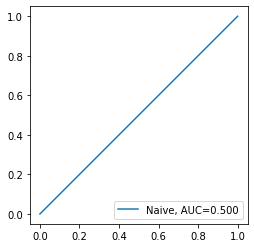

In [53]:
c = onp.ones(5000)
print("Accuracy:", sum(c==y_test)/5000)
    
plot_ROC(onp.ones(D), "Naive",data_val, y_val)

## 2.2 Naive Gradient Descent

In [157]:
n_iter = 10000
learning_rate = 0.001
loss_train_hist=[]; loss_val_hist = []

beta = onp.copy(beta_init)
best_beta_gd = onp.copy(beta_init)
#current_lowestloss_update = []

#current_lowest_loss = loss(beta_min,data_val,y_val) #on the validation set for later comparison

start = time.time()
for k in range(n_iter):
    gradient = grad_loss(beta,data_train,y_train)
    beta = beta-learning_rate*gradient

    loss_train = loss(beta,data_train,y_train)
    loss_val = loss(beta,data_val,y_val)
    
    if loss_val_hist:
        if loss_val <= loss_val_hist[-1]:
            best_beta_gd = beta
        
    #acc_train_list.append(accuracy_train)
    #acc_val_list.append(accuracy_val)
    loss_train_hist.append(loss_train)
    loss_val_hist.append(loss_val)
    
    timing = time.time() - start
    print("Iteration:{0:.0f} \t time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(k, 
                                                                                                 timing, 
                                                                                                loss_train, 
                                                                                                loss_val))

Iteration:0 	 time:0 	 Loss(train):0.702 	 Loss(val):0.701
Iteration:1 	 time:8 	 Loss(train):0.693 	 Loss(val):0.690
Iteration:2 	 time:13 	 Loss(train):0.691 	 Loss(val):0.688
Iteration:3 	 time:16 	 Loss(train):0.690 	 Loss(val):0.687
Iteration:4 	 time:21 	 Loss(train):0.689 	 Loss(val):0.687
Iteration:5 	 time:26 	 Loss(train):0.689 	 Loss(val):0.686
Iteration:6 	 time:31 	 Loss(train):0.688 	 Loss(val):0.685
Iteration:7 	 time:36 	 Loss(train):0.687 	 Loss(val):0.685
Iteration:8 	 time:41 	 Loss(train):0.686 	 Loss(val):0.684
Iteration:9 	 time:46 	 Loss(train):0.686 	 Loss(val):0.683
Iteration:10 	 time:51 	 Loss(train):0.685 	 Loss(val):0.683
Iteration:11 	 time:55 	 Loss(train):0.684 	 Loss(val):0.682
Iteration:12 	 time:58 	 Loss(train):0.684 	 Loss(val):0.682
Iteration:13 	 time:63 	 Loss(train):0.683 	 Loss(val):0.681
Iteration:14 	 time:68 	 Loss(train):0.683 	 Loss(val):0.680
Iteration:15 	 time:73 	 Loss(train):0.682 	 Loss(val):0.680
Iteration:16 	 time:78 	 Loss(train)

Iteration:133 	 time:606 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:134 	 time:611 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:135 	 time:616 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:136 	 time:621 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:137 	 time:626 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:138 	 time:631 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:139 	 time:636 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:140 	 time:641 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:141 	 time:646 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:142 	 time:651 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:143 	 time:655 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:144 	 time:660 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:145 	 time:665 	 Loss(train):0.647 	 Loss(val):0.652
Iteration:146 	 time:670 	 Loss(train):0.647 	 Loss(val):0.652
Iteration:147 	 time:675 	 Loss(train):0.647 	 Loss(val):0.651
Iteration:148 	 time:679 	 Loss(train):0.647 	 Loss(val

KeyboardInterrupt: 

Text(0.5, 1.0, 'Naive Gradient Descent')

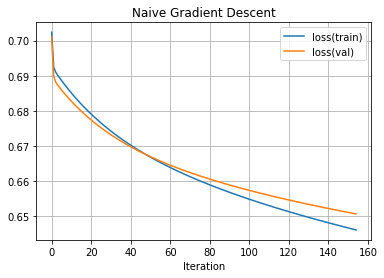

In [158]:
plt.plot(loss_train_hist, label="loss(train)")
plt.plot(loss_val_hist, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("Iteration")
plt.title("Naive Gradient Descent")

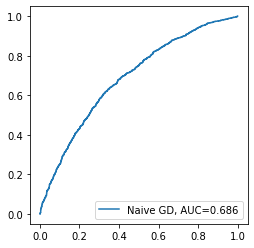

In [161]:
plot_ROC(best_beta_gd, "Naive GD", data_test)

In [188]:
for i in list(range(1,11)):
    acc = accuracy(best_beta_gd, data_val, y_val, i/10)
    print("Threshold: {0:.1f} \t Accuracy: {1:.3f}".format(i/10, acc))

Threshold: 0.1 	 Accuracy: 0.500
Threshold: 0.2 	 Accuracy: 0.502
Threshold: 0.3 	 Accuracy: 0.520
Threshold: 0.4 	 Accuracy: 0.581
Threshold: 0.5 	 Accuracy: 0.628
Threshold: 0.6 	 Accuracy: 0.572
Threshold: 0.7 	 Accuracy: 0.517
Threshold: 0.8 	 Accuracy: 0.500
Threshold: 0.9 	 Accuracy: 0.500
Threshold: 1.0 	 Accuracy: 0.500


The Naive Gradient Descent algorithm achieved an AUC of _ and accuracy of _ at threshold _ . This beats the baseline model but takes extremely long to run, approximately _ .

## 2.3 Stochastic Gradient Descent + Momentum

To compensate for the time cost of Naive Gradient Descent, we attempt to optimise the loss function with stochastic gradient descent with the parameters specified below.

In [54]:
n_epoch = 100
batch_size = 100  # size of the mini-batch
mov_avg_param = 0.8 # added to smooth the loss graph
learning_rate = 0.001
loss_train_hist = []; loss_val_hist = []

#initialize the gradient
beta = onp.copy(beta_init)
gradient = grad_loss(beta, data_train, y_train)
best_beta_sgdm = onp.zeros(D) # best model

start = time.time()
for epoch in range(n_epoch):
    #let us divide the learning by 2 every 10 epoch
    if epoch % 10 == 0 and epoch >= 1:
        learning_rate = learning_rate/2.
        
    for k in range(ntrain_img // batch_size):  #number of batch per epoch
        #select at random "batch_size" random data point
        index_ = onp.random.choice(ntrain_img, batch_size, replace=False)

        gradient_local = grad_loss(beta, data_train[index_], y_train[index_])

        #moving average of the gradient
        gradient = gradient*mov_avg_param + (1-mov_avg_param)*gradient_local

        #gradient descent update
        beta = beta - learning_rate * gradient
    
    loss_train = loss(beta, data_train, y_train)
    loss_val = loss(beta, data_val, y_val)
    
    if len(loss_val_hist)>0:
        if loss_val <= loss_val_hist[-1]:
            best_beta_sgdm = beta # save the model with the lowest validation loss
        
    loss_train_hist.append(loss_train)
    loss_val_hist.append(loss_val)
    
    timing = time.time() - start
    if (epoch == 99) or not(epoch % 20):
        print("epoch:{0:.0f} \t time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(epoch, 
                                                                                                 timing, 
                                                                                                loss_train, 
                                                                                                loss_val))

epoch:0 	 time:3 	 Loss(train):0.669 	 Loss(val):0.718
epoch:20 	 time:67 	 Loss(train):0.601 	 Loss(val):0.615
epoch:40 	 time:150 	 Loss(train):0.594 	 Loss(val):0.600
epoch:60 	 time:231 	 Loss(train):0.592 	 Loss(val):0.592
epoch:80 	 time:313 	 Loss(train):0.592 	 Loss(val):0.593
epoch:99 	 time:376 	 Loss(train):0.592 	 Loss(val):0.594


Text(0.5, 1.0, 'Stochastic Gradient Descent')

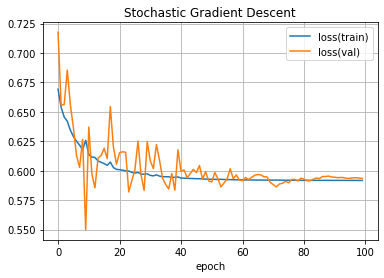

In [56]:
plt.plot(loss_train_hist, label="loss(train)")
plt.plot(loss_val_hist, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent")

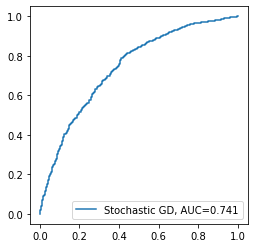

In [57]:
plot_ROC(best_beta_sgdm, "Stochastic GD", data_val, y_val)

In [58]:
for i in list(range(1,11)):
    acc = accuracy(best_beta_sgdm, data_val, y_val, i/10)
    print("Threshold: {0:.1f} \t Accuracy: {1:.3f}".format(i/10, acc))

Threshold: 0.1 	 Accuracy: 0.778
Threshold: 0.2 	 Accuracy: 0.782
Threshold: 0.3 	 Accuracy: 0.796
Threshold: 0.4 	 Accuracy: 0.781
Threshold: 0.5 	 Accuracy: 0.695
Threshold: 0.6 	 Accuracy: 0.548
Threshold: 0.7 	 Accuracy: 0.371
Threshold: 0.8 	 Accuracy: 0.259
Threshold: 0.9 	 Accuracy: 0.224
Threshold: 1.0 	 Accuracy: 0.222


The accuracy of the Stochastic Gradient Descent method is greatest at ~0.809 when the threshold is ~0.3, and the method has an AUC of 0.761. This classifier has a higher accuracy than the naive model.

## 2.4 L-BFGS

In [59]:
def loss_wrapper(beta):
    """ only one argument """
    return loss(beta, data_train, y_train)

grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

def gradient_wrapper(beta):
    """output is a numpy array"""
    return onp.array(grad_loss_wrapper(beta))

In [81]:
loss_train_hist = []; loss_val_hist = []
acc_val_hist = []
time_hist = []  # to save the compute time

best_beta_bfgs = onp.zeros(D) # to save best model
beta = onp.copy(beta_init)

def save_traj(beta):
    global best_beta_bfgs
    """ a function that saves a few statistics for later analysis"""
    loss_train = loss(beta, data_train, y_train)
    loss_val = loss(beta, data_val, y_val)
    timing = time.time() - start
    
    print("Time:{0:.3f} \t Loss(train):{1:.3f} \t Loss(val):{2:.3f}".format(timing, loss_train, loss_val))
    
    time_hist.append(timing)
    loss_train_hist.append(loss_train)
    loss_val_hist.append(loss_val)

    #acc_val = accuracy(beta, data_val, y_val)
    #acc_val_list.append(accuracy_val)
    
    if loss_val <= loss_val_hist[-1]: # save the model with the lowest validation loss
        best_beta_bfgs = beta
        
#run LBFGS
start = time.time()
onp.random.seed(0)
traj = scipy.optimize.minimize(fun = loss_wrapper, # function to minimize
                                x0 = onp.array(beta_init), # initial guess
                                method='L-BFGS-B',  # we want to use L-BFGS
                                jac=gradient_wrapper, # function that computes the gradient
                                callback=save_traj, # a function used to save some results for later plotting
                                options={"maxiter":100}) # maximum number of iterations

Time:11.399 	 Loss(train):0.693 	 Loss(val):0.722
Time:17.301 	 Loss(train):0.691 	 Loss(val):0.693
Time:23.004 	 Loss(train):0.689 	 Loss(val):0.680
Time:28.396 	 Loss(train):0.680 	 Loss(val):0.638
Time:33.648 	 Loss(train):0.669 	 Loss(val):0.616
Time:39.074 	 Loss(train):0.655 	 Loss(val):0.624
Time:44.527 	 Loss(train):0.648 	 Loss(val):0.649
Time:49.985 	 Loss(train):0.645 	 Loss(val):0.667
Time:55.463 	 Loss(train):0.641 	 Loss(val):0.681
Time:60.893 	 Loss(train):0.634 	 Loss(val):0.690
Time:66.388 	 Loss(train):0.624 	 Loss(val):0.678
Time:71.866 	 Loss(train):0.605 	 Loss(val):0.634
Time:77.569 	 Loss(train):0.595 	 Loss(val):0.603
Time:83.114 	 Loss(train):0.593 	 Loss(val):0.588
Time:88.605 	 Loss(train):0.592 	 Loss(val):0.581
Time:93.997 	 Loss(train):0.590 	 Loss(val):0.569
Time:99.535 	 Loss(train):0.585 	 Loss(val):0.563
Time:105.002 	 Loss(train):0.578 	 Loss(val):0.554
Time:113.341 	 Loss(train):0.574 	 Loss(val):0.579
Time:118.858 	 Loss(train):0.569 	 Loss(val):0.5

Text(0.5, 1.0, 'L-BFGS')

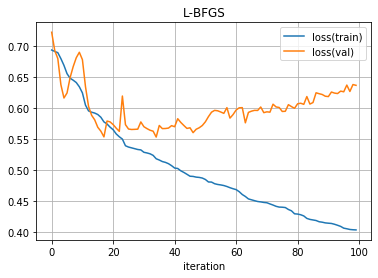

In [82]:
plt.plot(loss_train_hist, label="loss(train)")
plt.plot(loss_val_hist, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("iteration")
plt.title("L-BFGS")

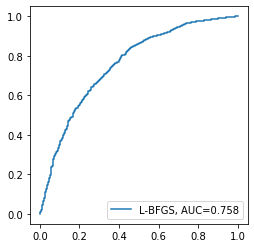

In [83]:
plot_ROC(best_beta_bfgs, "L-BFGS", data_val, y_val)

In [84]:
for i in list(range(1,11)):
    acc = accuracy(best_beta_bfgs, data_val, y_val, i/10)
    print("Threshold: {0:.1f} \t Accuracy: {1:.3f}".format(i/10, acc))

Threshold: 0.1 	 Accuracy: 0.804
Threshold: 0.2 	 Accuracy: 0.793
Threshold: 0.3 	 Accuracy: 0.774
Threshold: 0.4 	 Accuracy: 0.743
Threshold: 0.5 	 Accuracy: 0.703
Threshold: 0.6 	 Accuracy: 0.664
Threshold: 0.7 	 Accuracy: 0.610
Threshold: 0.8 	 Accuracy: 0.539
Threshold: 0.9 	 Accuracy: 0.428
Threshold: 1.0 	 Accuracy: 0.222


# 3. Improvements to Images

This section will explore if the model accuracies can be increased by either improving the image pre-processing.

## 3.1 Comparing colored images to grayscale

We load the images as `ptrain_imgc`, `pval_imgc`, `ptest_imgc` as the training, validation and test datasets respectively in color. This changes each image to a 135 by 95 by 3 array.

In [61]:
# load the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_imgc = onp.zeros((ntrain_img,h_n,w_n,3))

for k in range(ntrain_img):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    ptrain_imgc[k,:,:] = im

In [62]:
# load the images from the prelim validation set
nval_img = len(pval)
pval_ind = pval.index.values
pval_imgc = onp.zeros((nval_img,h_n,w_n,3))

for k in range(nval_img):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    pval_imgc[k,:,:] = im

In [63]:
# load the images from the test set
ntest_img = 5000
ptest_imgc = onp.zeros((ntest_img,h_n,w_n,3))

for k in range(ntest_img):
    im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
    im = resize(im, (h,w))
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    ptest_imgc[k,:,:] = im

In [64]:
D = h_n*w_n*3

data_trainc = ptrain_imgc.reshape(5330, D)
y_train = ptrain.to_numpy(copy=True)

data_valc = pval_imgc.reshape(3002, D)
y_val = pval.to_numpy(copy=True)

data_testc = ptest_imgc.reshape(5000, D)
y_test = test.to_numpy(copy=True)

beta_init = onp.random.normal(0., scale = 1./onp.sqrt(D), size=D)

The model is trained with a stochastic gradient descent algorithm.

In [67]:
n_epoch = 100
batch_size = 100  # size of the mini-batch
mov_avg_param = 0.8 # added to smooth the loss graph
learning_rate = 0.001
loss_train_hist = []; loss_val_hist = []

#initialize the gradient
beta = onp.copy(beta_init)
gradient = grad_loss(beta, data_trainc, y_train)
best_beta_sgdmc = onp.zeros(D) # best model

start = time.time()
for epoch in range(n_epoch):
    #let us divide the learning by 2 every 10 epoch
    if epoch % 10 == 0 and epoch >= 1:
        learning_rate = learning_rate/2.
        
    for k in range(ntrain_img // batch_size):  #number of batch per epoch
        #select at random "batch_size" random data point
        index_ = onp.random.choice(ntrain_img, batch_size, replace=False)

        gradient_local = grad_loss(beta, data_trainc[index_], y_train[index_])

        #moving average of the gradient
        gradient = gradient*mov_avg_param + (1-mov_avg_param)*gradient_local

        #gradient descent update
        beta = beta - learning_rate * gradient
    
    loss_train = loss(beta, data_trainc, y_train)
    loss_val = loss(beta, data_valc, y_val)
    
    if len(loss_val_hist)>0:
        if loss_val <= loss_val_hist[-1]:
            best_beta_sgdmc = beta # save the model with the lowest validation loss
        
    loss_train_hist.append(loss_train)
    loss_val_hist.append(loss_val)
    
    timing = time.time() - start
    if (epoch == 99) or not(epoch % 20):
        print("epoch:{0:.0f} \t time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(epoch, 
                                                                                                 timing, 
                                                                                                loss_train, 
                                                                                                loss_val))

epoch:0 	 time:7 	 Loss(train):0.642 	 Loss(val):0.635
epoch:20 	 time:196 	 Loss(train):0.548 	 Loss(val):0.557
epoch:40 	 time:388 	 Loss(train):0.540 	 Loss(val):0.559
epoch:60 	 time:569 	 Loss(train):0.538 	 Loss(val):0.560
epoch:80 	 time:749 	 Loss(train):0.538 	 Loss(val):0.560
epoch:99 	 time:917 	 Loss(train):0.538 	 Loss(val):0.557


Text(0.5, 1.0, 'Stochastic Gradient Descent on Colored')

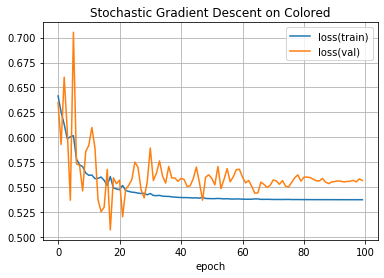

In [68]:
plt.plot(loss_train_hist, label="loss(train)")
plt.plot(loss_val_hist, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent on Colored")

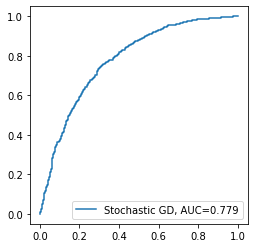

In [69]:
plot_ROC(best_beta_sgdmc, "Stochastic GD", data_valc, y_val)

In [70]:
for i in list(range(1,11)):
    acc = accuracy(best_beta_sgdmc, data_valc, y_val, i/10)
    print("Threshold: {0:.1f} \t Accuracy: {1:.3f}".format(i/10, acc))

Threshold: 0.1 	 Accuracy: 0.781
Threshold: 0.2 	 Accuracy: 0.805
Threshold: 0.3 	 Accuracy: 0.817
Threshold: 0.4 	 Accuracy: 0.789
Threshold: 0.5 	 Accuracy: 0.732
Threshold: 0.6 	 Accuracy: 0.615
Threshold: 0.7 	 Accuracy: 0.471
Threshold: 0.8 	 Accuracy: 0.329
Threshold: 0.9 	 Accuracy: 0.242
Threshold: 1.0 	 Accuracy: 0.222


Compared to using grayscale images, training the model on colored images improves the accuracy (81.7 at threshold 0.3) and AUC=0.779, at the cost of increasing the time spent from 317s to 917s.

## 3.2 Comparing 'eyes only' to facial images

Observing the $\beta$'s from the best model generated by naive Gradient Descent below, it appears that areas near the eyes and the cheekbones have greater weight in determining if one is classified as young or old. This suggests that training the model on images cropped to this extent may result in some improvements to time.

In [ ]:
best_beta_ngd = pd.read_csv('beta_ngd.csv')
best_beta_ngd = np.asarray(best_beta_ngd['beta_10000_min'])
plt.imshow(best_beta_ngd.reshape(h_n,w_n), cmap='gray')

We load the images as `ptrain_imgce`, `pval_imgce`, `ptest_imgce` as the training, validation and test datasets respectively in color and crop the original images to the extent that includes only eyes and cheekbones. This changes each image to a $50*85*3$ array.

In [71]:
h_e, w_e = 145-95, 130-45
# load the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_imgce = onp.zeros((ntrain_img,h_e,w_e,3))

for k in range(ntrain_img):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = im/255. # rescale
    im = im[95:145,45:130] # crop to eyes
    ptrain_imgce[k,:,:] = im
    
# load the images from the prelim validation set
nval_img = len(pval)
pval_ind = pval.index.values
pval_imgce = onp.zeros((nval_img,h_e,w_e,3))

for k in range(nval_img):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = im/255. # rescale
    im = im[95:145,45:130] # crop to eyes
    pval_imgce[k,:,:] = im
    
# load the images from the test set
ntest_img = 5000
ptest_imgce = onp.zeros((ntest_img,h_e,w_e,3))

for k in range(ntest_img):
    im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
    im = resize(im, (h,w))
    im = im/255. # rescale
    im = im[95:145,45:130] # crop to face
    ptest_imgce[k,:,:] = im

In [72]:
D = h_e*w_e*3

data_traince = ptrain_imgce.reshape(5330, D)
y_train = ptrain.to_numpy(copy=True)

data_valce = pval_imgce.reshape(3002, D)
y_val = pval.to_numpy(copy=True)

data_testce = ptest_imgce.reshape(5000, D)
y_test = test.to_numpy(copy=True)

beta_init = onp.random.normal(0., scale = 1./onp.sqrt(D), size=D)

The model is trained with a stochastic gradient descent algorithm.

In [74]:
n_epoch = 100
batch_size = 100  # size of the mini-batch
mov_avg_param = 0.8 # added to smooth the loss graph
learning_rate = 0.001
loss_train_hist = []; loss_val_hist = []

#initialize the gradient
beta = onp.copy(beta_init)
gradient = grad_loss(beta, data_traince, y_train)
best_beta_sgdmce = onp.zeros(D) # best model

start = time.time()
for epoch in range(n_epoch):
    #let us divide the learning by 2 every 10 epoch
    if epoch % 10 == 0 and epoch >= 1:
        learning_rate = learning_rate/2.
        
    for k in range(ntrain_img // batch_size):  #number of batch per epoch
        #select at random "batch_size" random data point
        index_ = onp.random.choice(ntrain_img, batch_size, replace=False)

        gradient_local = grad_loss(beta, data_traince[index_], y_train[index_])

        #moving average of the gradient
        gradient = gradient*mov_avg_param + (1-mov_avg_param)*gradient_local

        #gradient descent update
        beta = beta - learning_rate * gradient
    
    loss_train = loss(beta, data_traince, y_train)
    loss_val = loss(beta, data_valce, y_val)
    
    if len(loss_val_hist)>0:
        if loss_val <= loss_val_hist[-1]:
            best_beta_sgdmce = beta # save the model with the lowest validation loss
        
    loss_train_hist.append(loss_train)
    loss_val_hist.append(loss_val)
    
    timing = time.time() - start
    if (epoch == 99) or not(epoch % 20):
        print("epoch:{0:.0f} \t time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(epoch, 
                                                                                                 timing, 
                                                                                                loss_train, 
                                                                                                loss_val))

epoch:0 	 time:3 	 Loss(train):0.676 	 Loss(val):0.728
epoch:20 	 time:62 	 Loss(train):0.593 	 Loss(val):0.602
epoch:40 	 time:123 	 Loss(train):0.587 	 Loss(val):0.590
epoch:60 	 time:185 	 Loss(train):0.586 	 Loss(val):0.597
epoch:80 	 time:248 	 Loss(train):0.585 	 Loss(val):0.595
epoch:99 	 time:307 	 Loss(train):0.585 	 Loss(val):0.595


Text(0.5, 1.0, 'Stochastic Gradient Descent on Eyes')

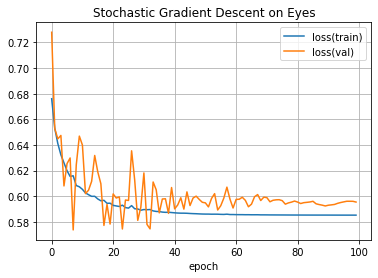

In [75]:
plt.plot(loss_train_hist, label="loss(train)")
plt.plot(loss_val_hist, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent on Eyes")

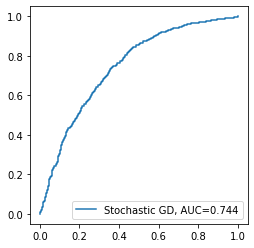

In [76]:
# function to plot ROC curve
plot_ROC(best_beta_sgdmce, "Stochastic GD", data_valce, y_val)

In [77]:
for i in list(range(1,11)):
    acc = accuracy(best_beta_sgdmce, data_valce, y_val, i/10)
    print("Threshold: {0:.1f} \t Accuracy: {1:.3f}".format(i/10, acc))

Threshold: 0.1 	 Accuracy: 0.777
Threshold: 0.2 	 Accuracy: 0.780
Threshold: 0.3 	 Accuracy: 0.802
Threshold: 0.4 	 Accuracy: 0.783
Threshold: 0.5 	 Accuracy: 0.690
Threshold: 0.6 	 Accuracy: 0.547
Threshold: 0.7 	 Accuracy: 0.389
Threshold: 0.8 	 Accuracy: 0.276
Threshold: 0.9 	 Accuracy: 0.231
Threshold: 1.0 	 Accuracy: 0.222


This results in an accuracy of 0.802 with a threshold of 0.3, which beats the naive model. However, this has a lower AUC and accuracy compared to model in section 3.1 trained on the full-face colored images. This suggests that information is lost from removing parts of the images outside the eyes. Nonetheless, this method still has some merit given the reduction in time from 917s to 307s.